In [1]:
import tiktoken
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from typing import List,Tuple
import openai
import os
import numpy as np
import pandas as pd
import dotenv
import json
import matplotlib.pyplot as plt

import llm

dotenv.load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/ubuntu/.local/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /usr/lib/x86_64-linux-gnu/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 9.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /home/ubuntu/.local/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


In [2]:
TEXT_FILE = "data/input/MSA_Juniper_IBM.txt"

## Read text and chunk it up

In [3]:
encoding = tiktoken.get_encoding("cl100k_base")
def token_count(text):
    tokens = encoding.encode(text)
    return len(tokens)

with open(TEXT_FILE) as f:
    all_text = f.read()
    # replace non-asci characters
    all_text = all_text.encode("ascii", errors="ignore").decode()

print(f"Total tokens: {token_count(all_text)}")


def split_text(text, chunk_size=400):
    overlap = chunk_size // 4
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=overlap)
    chunks = splitter.split_text(text)
    return chunks

chunks_400 = split_text(all_text, chunk_size=400)
chunks_1000 = split_text(all_text, chunk_size=1000)
chunks_4000 = split_text(all_text, chunk_size=4000)
chunks = chunks_400 + chunks_1000 + chunks_4000

print(f"Number of chunks: 400: {len(chunks_400)}, 1000: {len(chunks_1000)}, 4000: {len(chunks_4000)}")


Total tokens: 45290
Number of chunks: 400: 865, 1000: 393, 4000: 93


## Embeddings

In [4]:
def get_embedding_ada(texts:List[str]):
    model = "text-embedding-ada-002"
    data = openai.Embedding.create(input = texts, model=model)['data']
    return np.array([d['embedding'] for d in data])

def load_embeddings_ada(texts:List[str]):
    emb_file = "data/embeddings/ada.npy"
    if os.path.exists(emb_file):
        return np.load(emb_file)
    embs = get_embedding_ada(texts)
    os.makedirs(os.path.dirname(emb_file), exist_ok=True)
    np.save(emb_file, embs)
    return embs

embs_ada = load_embeddings_ada(chunks)
    

In [5]:
emb_functions = {
    "ada": get_embedding_ada,
}
embeddings = {
    "ada": embs_ada,
}

## HyDe

In [6]:
def hypothetical_answers(question, n=3, model="turbo", prompt_key="hyde_general"):
    with open(f"prompts/{prompt_key}.txt") as f:
        prompt = f.read()
    answers = llm.complete(prompt, question, model=model, temp=0.7, max_tokens=150, n=n, return_list=True)
    # save answers to file
    question_name = question.replace(" ", "_").replace("?", "")[:20]
    folder = f"output/hyde/{question_name}"
    os.makedirs(folder, exist_ok=True)
    with open(f"{folder}/{prompt_key}_{model}.txt", "w") as f:
        f.write("\n\n\n####\n\n\n".join(answers))
    return answers

def avg_embedding(answers, emb_type="ada"):
    answ_embs = emb_functions[emb_type](answers)
    avg = np.mean(answ_embs, axis=0)
    # print the mean cosine similarity to the average
    closeness = np.average([np.dot(avg, emb) for emb in answ_embs])
    print(f"Similarity within hypotheticals: {closeness:.3f}")
    return avg

## Retrieval

In [7]:
def get_context_cos(text, emb_type="ada", top_k=1000, text_embedding=None) -> List[Tuple[str, float]]:
    if text_embedding is None:
        text_embedding = emb_functions[emb_type]([text])[0]
    embs = embeddings[emb_type]
    
    # find argmax of cosine similarity. All vectors are normalized, so this is equivalent to argmax of dot product
    cos_sim = np.dot(embs, text_embedding)
    top_k_indices = np.argsort(cos_sim)[-top_k:]
    top_k_indices = top_k_indices[::-1]
    return [(chunks[i], cos_sim[i]) for i in top_k_indices]

def print_context(context: List[Tuple[str, float]]):
    for i, (chunk, cos) in enumerate(context):
        print("-"*30 + f" Result {i}: {cos:.3f} " + "-"*30)
        print(chunk)

def answer_pos_in_context(context: List[Tuple[str, float]], answer)-> Tuple[int, float]:
    for i, (chunk, cos) in enumerate(context):
        if answer in chunk:
            return i, cos
    return None, None

def eval_context(context, answer, do_print_context=False):
    #context = get_context_cos(question, emb_type=emb_type, top_k=top_k)
    top_score = context[0][1]
    answer_pos, answer_score = answer_pos_in_context(context, answer)
    print(f"Answer pos: {answer_pos}. Answer score: {answer_score:.3f}. First result score: {top_score:.3f}")
    if do_print_context:
        print_context(context)
    return answer_pos

def run_test(question, answer, emb_type="ada", top_k=1000, do_print_context=False):
    context = get_context_cos(question, emb_type=emb_type, top_k=top_k)
    answer_pos = eval_context(context, answer, do_print_context=do_print_context)
    return answer_pos

def run_test_hyde(question, answer, emb_type="ada", model="turbo", prompt_key="hyde_general", top_k=1000, do_print_context=False):
    hyde_answer_emb = avg_embedding(hypothetical_answers(question, model=model, prompt_key=prompt_key), emb_type=emb_type)
    context = get_context_cos(question, emb_type=emb_type, top_k=top_k, text_embedding=hyde_answer_emb)
    answer_pos = eval_context(context, answer, do_print_context=do_print_context)
    return answer_pos


In [8]:
run_test("How often do we have access to training by IBM?", "once every Contract Year or upon request after at least thirty(30) days")


Answer pos: 1. Answer score: 0.802. First result score: 0.807


1

# Benchmark

In [9]:
with open("data/benchmark_qa.json") as f:
    qa_data = json.load(f)

embedding_types = ["ada"]

ranks = {}

def run_tests(test_func, test_name):
    # Baseline (no hyde)
    for emb_type in embedding_types:
        name = f"{test_name}_{emb_type}"
        ranks[name] = []
        for i, qa in enumerate(qa_data):
            print(f"Running {name} on {i+1}/{len(qa_data)}")
            answer_pos = test_func(qa["q"], qa["a"], emb_type=emb_type)
            ranks[name].append(answer_pos)

run_tests(run_test, "baseline")

##### Hyde tests
models = ["turbo", "gpt-4"]
prompt_keys = ["hyde_general", "hyde_one_shot"]

for model in models:
    for prompt_key in prompt_keys:
        name = f"{prompt_key}_{model}"
        func = lambda q, a, emb_type="ada": run_test_hyde(q, a, emb_type=emb_type, model=model, prompt_key=prompt_key)
        run_tests(func, name)


##### Vicuna
models = ["vicuna-7-finetuned", "vicuna-7"]
for model in models:
    name = f"{model}"
    func = lambda q, a, emb_type="ada": run_test_hyde(q, a, emb_type=emb_type, model=model, prompt_key="hyde_general")
    run_tests(func, name)

Running baseline_ada on 1/7
Answer pos: 178. Answer score: 0.758. First result score: 0.794
Running baseline_ada on 2/7
Answer pos: 8. Answer score: 0.787. First result score: 0.804
Running baseline_ada on 3/7
Answer pos: 235. Answer score: 0.800. First result score: 0.849
Running baseline_ada on 4/7
Answer pos: 11. Answer score: 0.792. First result score: 0.831
Running baseline_ada on 5/7
Answer pos: 2. Answer score: 0.798. First result score: 0.801
Running baseline_ada on 6/7
Answer pos: 14. Answer score: 0.788. First result score: 0.809
Running baseline_ada on 7/7
Answer pos: 10. Answer score: 0.797. First result score: 0.812
Running hyde_general_turbo_ada on 1/7
using cached result
Similarity within hypotheticals: 0.943
Answer pos: 5. Answer score: 0.819. First result score: 0.830
Running hyde_general_turbo_ada on 2/7
using cached result
Similarity within hypotheticals: 0.951
Answer pos: 67. Answer score: 0.800. First result score: 0.839
Running hyde_general_turbo_ada on 3/7
using 

In [10]:
def print_results(ranks, do_print=False):
    # make table, rows is questions, columns is "question", and then all methods methods
    df = pd.DataFrame(columns=["question"] + list(ranks.keys()))
    for i, qa in enumerate(qa_data):
        row = [qa["q"]]
        for name, rank in ranks.items():
            row.append(rank[i])
        df.loc[i] = row
    if do_print:
        print(df.to_string(line_width=150))
    return df
df = print_results(ranks, True)
df.describe()

                                                                                                                 question  baseline_ada  \
0                                                      Will IBM help us getting started? Will they support us on the way?           178   
1                                                                          If we get aquired, do we have to stick to IBM?             8   
2  Is IBM allowed to subcontract any of its obligations under the MSA to third parties, and if so, under what conditions?           235   
3                                                                                 Are they allowed to use subcontractors?            11   
4                                                                       Can IBM change the price? Under which conditions?             2   
5                                                                  Are they allowed to share our data with third parties?            14   
6                          

,baseline_ada,hyde_general_turbo_ada,hyde_one_shot_turbo_ada,hyde_general_gpt-4_ada,hyde_one_shot_gpt-4_ada,vicuna-7-finetuned_ada,vicuna-7_ada
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,65.428571,26.571429,26.714286,18.428571,7.857143,84.571429,51.857143
std,97.832948,32.745774,39.436507,30.642330,9.118271,98.413849,47.579507
min,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,4.000000
25%,9.000000,5.500000,6.500000,2.500000,1.000000,10.000000,6.500000
50%,11.000000,8.000000,15.000000,4.000000,3.000000,47.000000,62.000000
75%,96.000000,43.000000,22.500000,17.500000,13.500000,146.500000,78.500000
max,235.000000,80.000000,114.000000,85.000000,23.000000,231.000000,127.000000


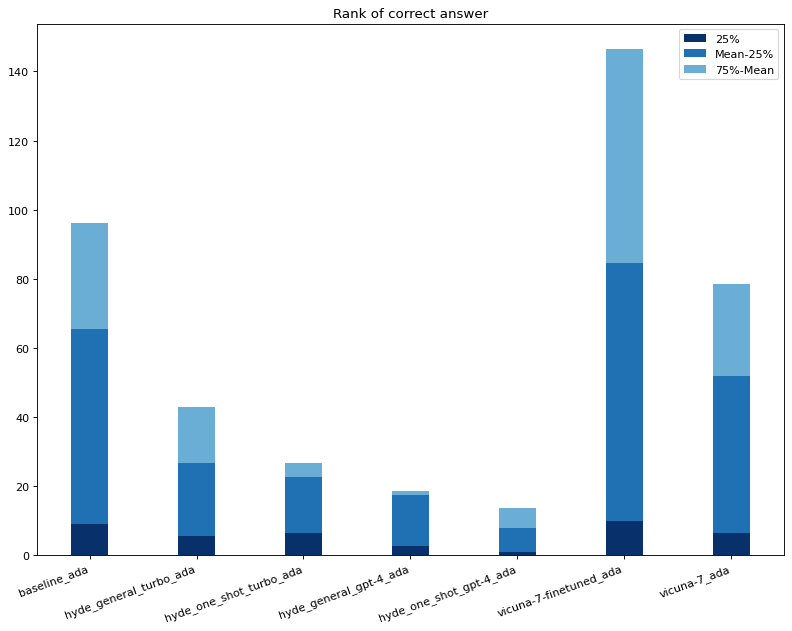

In [11]:
stats = df.describe()


selected_stats = pd.DataFrame()
selected_stats['25%'] = stats.loc['25%']
selected_stats['mean-25%'] = stats.loc['mean'] - stats.loc['25%']
selected_stats['75%-mean'] = stats.loc['75%'] - stats.loc['mean']
selected_stats = selected_stats.drop('question', errors='ignore')  # Drop 'question' column if it's not required
labels = selected_stats.index
mean_minus_25 = selected_stats['mean-25%']
twenty_five = selected_stats['25%']
seventy_five_minus_mean = selected_stats['75%-mean']

width = 0.35  # Width of the bars

# Get colormap
cmap = plt.get_cmap('Blues')
colors = [cmap(i) for i in np.linspace(0.5, 1, 3)]

fig, ax = plt.subplots(figsize=(10, 8), dpi=80)

# Stacked bar chart
rects1 = ax.bar(labels, twenty_five, width, label='25%',color=colors[2])
rects2 = ax.bar(labels, mean_minus_25, width, bottom=twenty_five, label='Mean-25%',color=colors[1])
rects3 = ax.bar(labels, seventy_five_minus_mean, width, bottom=twenty_five+mean_minus_25, label='75%-Mean',color=colors[0])

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_title('Rank of correct answer')
ax.legend()

plt.xticks(rotation=20, ha='right')  # Rotate x-axis labels for better visibility if they're long

fig.tight_layout()
plt.show()

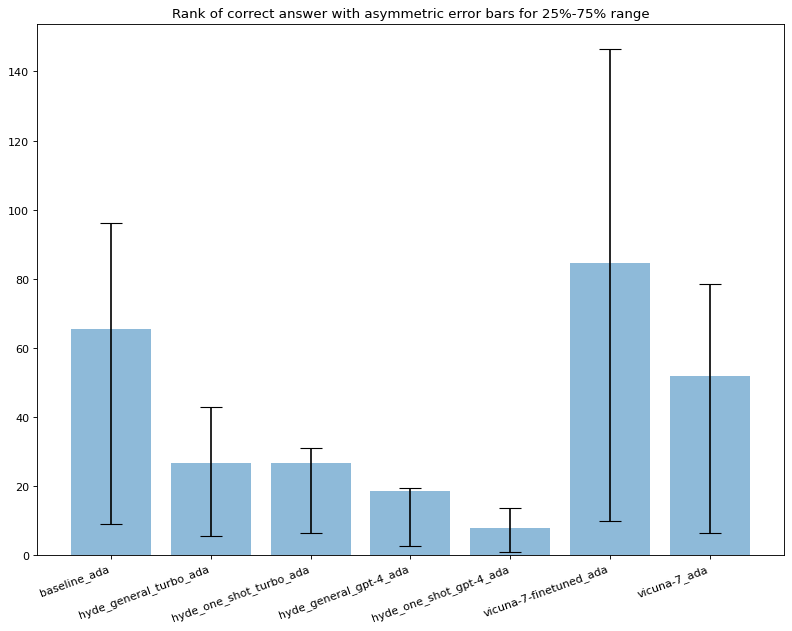

In [12]:
# Create a DataFrame with the statistics you need
selected_stats = pd.DataFrame()
selected_stats['mean'] = stats.loc['mean']
selected_stats['25%'] = stats.loc['25%']
selected_stats['75%'] = stats.loc['75%']
selected_stats = selected_stats.drop('question', errors='ignore')  # Drop 'question' column if it's not required

# Calculate the errors
lower_error = np.abs(selected_stats['mean'] - selected_stats['25%'])
upper_error = np.abs(selected_stats['75%'] - selected_stats['mean'])
asymmetric_error = [lower_error, upper_error]

labels = selected_stats.index
means = selected_stats['mean']

fig, ax = plt.subplots(figsize=(10, 8), dpi=80)

# Bar plot with asymmetric error bars
rects = ax.bar(labels, means, yerr=asymmetric_error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_title('Rank of correct answer with asymmetric error bars for 25%-75% range')

# Rotate x-axis labels for better visibility if they're long
plt.xticks(rotation=20, ha='right') 

fig.tight_layout()
plt.show()

In [16]:
with open(f"prompts/hyde_general.txt") as f:
    prompt = f.read()
question = qa_data[0]["q"]
print(question)
answers = llm.complete(prompt, question, model="vicuna-7-finetuned", ignore_cache=True, max_tokens=400)
print(answers[0])


Will IBM help us getting started? Will they support us on the way?
llama: running completion
Y
